## Geno2freq
1. HO data
2. UPA8 data

In [3]:
%%writefile /mnt/solexa/mel_yang/BGI/geno2freq_HO.py

############################################################################
############## TURNS .GENO FILE TO .FREQ FILE, BGI FORMAT ##################
############################################################################

## Freq format is chr, pos, popnfreq
## Nind format is same order popn, followed by number of individuals

import collections
import tabix
import itertools
import numpy as np
from scipy.stats import bernoulli
from HOdata import eur,eas,allnamers,otherasia,allpacific,anceur2

#pd="/Users/melyang/Documents/BGI_HanFreq/"
pd="/mnt/solexa/mel_yang/BGI/"
datpd="/public/adna/qiaomei_fu/HO/"
datpd="/mnt/solexa/mel_yang/BGI/"
fh="ind_A_v13_TBH6"
fh="UPA_all8"

indfile=open(datpd+fh+".ind",'r')
myinds=collections.defaultdict(list)
for ind,line in enumerate(indfile):
    myinds[line.split()[2]].append(ind)
indfile.close()
print "Read in",datpd+fh+".ind"
#print myinds.keys()

ancasn1=["Huoshaogou","Wuba","Xiaoshuangqiao","Guandimiao","Shengedaliang",
         "Muzhuzhuliang","Xinhua","Wuzhuangguo","Shimao","Tonglin",
         "Dashuitian","Taosi","Redilong",
         "Butaxiongqu","Gelintang","Yingpanshan","Mougou","Sanheyi","Yusu",
         "Jinchankou","Jomon"]
ancasn=["Tianyuan",'Longlin','Longlin_com','Xinyi','Daxi',
        'LiangDaoChineseNeolithic','Boisman_MN','BoshanChineseNeolithic',
        'Bbdong', 'Linzi','HDYM1','HQSDW','Zongri','Pukagongma',
        'Chokhopani1','Mebrak','Samdzong']
afr=["Yoruba","Mandenka","Mbuti","Dinka","Ju_hoan_North"]

popns=eur+eas+ancasn+ancasn1+allnamers+otherasia+allpacific+anceur2+afr
popns+=["Israel_Natufian","Chimp","Altai","Denisovan"]


upasnp=open(datpd+fh+".snp","r")
mysnps=[ tuple(line.split()) for line in upasnp ]
upasnp.close()
print "Read in",pd+fh+".snp"


mysets=["BGI/OnlyHan","BGI/ByProvince","BGI/Minority"]
BGIsnpfiles=[tabix.open(pd+mysets[ind]+"_siteinfo.txt.gz") for ind,i in enumerate(mysets)]
BGIfreqfiles=[tabix.open(pd+mysets[ind]+"_freqs.txt.gz") for ind,i in enumerate(mysets)]

upaindfile=open(pd+fh+"_2_nind.txt","w")
for i in popns: upaindfile.write("%s\t%i\n" % (i,len(myinds[i])))
upaindfile.close()

upafreqfile=open(pd+fh+"_2_freqs.txt","w")
conflictfile=open(pd+fh+"_2_conflictwBGI.txt","w")

num=0
upageno=open(datpd+fh+".geno","r")
for ind,line in enumerate(upageno):
    x=line.split()
    snpinfo=mysnps[ind]
    upaalleles=snpinfo[-2]+snpinfo[-1]
    if snpinfo[1] == '23': mychrname='X'
    elif snpinfo[1] == '24': mychrname='Y'
    else: mychrname=snpinfo[1]
        
    mySNPqueries=[BGI.query("chr"+mychrname,int(snpinfo[3])-1,int(snpinfo[3])) for BGI in BGIsnpfiles]
    records=[i for i in mySNPqueries[0]]+[i for i in mySNPqueries[1]]+[i for i in mySNPqueries[2]]
    #myfqueries=[BGI.query("chr"+mychrname,int(snpinfo[3])-1,int(snpinfo[3])) for BGI in BGIfreqfiles]
    #recordsf=[i[2:] for i in myfqueries[0]]+[i[2:] for i in myfqueries[1]]
    #recordsf=[i if i not in ["nan","-nan"] else 99 for i in list(itertools.chain.from_iterable(recordsf)) ]
    #recordsf=np.array(recordsf,dtype="float")
    
    if len(records)==0: conflictfile.write("noBGIrecord\tchr%s\t%s\t%s\t%s\n" % (mychrname,snpinfo[3],"NA","NA")); continue
    elif len(records) in [1,2]: conflictfile.write("badBGIrecord\tchr%s\t%s\t%s\t%s\n" % (mychrname,snpinfo[3],"NA","NA")); continue
    elif len(records)==3: 
        if upaalleles == records[0][-1] or upaalleles[::-1] == records[0][-1]: pass
        else: conflictfile.write("badalleles\tchr%s\t%s\t%s\t%s\n" % (mychrname,snpinfo[3],upaalleles,records[0][-1])); continue
        myfreqs=[]
        for mypop in popns:
            mygenos = np.array([line[indpos] for indpos in myinds[mypop] if line[indpos] != '9' ],dtype='int')  ##Only look at nonmissing data
            
            if len(mygenos)==0: myfreqs.append("-nan")
            else: 
                if upaalleles == records[0][-1]: myfreqs.append(str(1-((mygenos.sum()/2.0)/(len(mygenos)))))
                elif upaalleles[::-1] == records[0][-1]: myfreqs.append(str((mygenos.sum()/2.0)/(len(mygenos))))
                else: print 'what?', mychrname,snpinfo[3],upaalleles,records[0][-1]
            if mypop=="Dai": print "%s\t%s\t%s\t%s" % ("\t".join(records[0]),upaalleles, mygenos, myfreqs[-1] )
                
        mystr='\t'.join(myfreqs)
        upafreqfile.write( "chr%s\t%s\t%s\n" % (mychrname,snpinfo[3],mystr) )
    else: conflictfile.write("duplicates\tchr%s\t%s\t%s\t%s\n" % (mychrname,snpinfo[3],upaalleles,records[0][-1])); continue
        
    #if num==20: break
    num+=1
conflictfile.close()
upafreqfile.close()

Overwriting /mnt/solexa/mel_yang/BGI/geno2freq_HO.py


In [8]:
x="0.727272727273	0.939393939394	0.857142857143	0.727272727273	0.772727272727	0.777777777778	0.774193548387	0.75	0.675	0.9	0.875	0.75	0.85	0.9	0.875	0.772727272727	0.775	0.75	0.833333333333	0.8	0.833333333333	0.84	0.9	0.759259259259	0.809523809524	0.928571428571	0.855263157895	0.895833333333	0.75	0.875	0.75	0.666666666667	0.785714285714	0.888888888889	0.916666666667	0.6875	0.611111111111	0.642857142857	0.6	0.5	0.9375	0.8125	0.75	0.727272727273	0.954545454545	0.85	0.9375	0.75	1.0	0.727272727273	0.964285714286	0.794871794872	0.875	0.65	0.77397260274	0.933333333333	0.625	0.859370.85	0.909090909091	0.833333333333	1.0	0.827272727273	0.785714285714	0.862745098039	0.809523809524	0.85	0.9	1.0	0.833333333333	0.909090909091	0.62962962963	0.833333333333	1.0	0.95	0.9	0.9	0.75	0.911764705882	0.875	0.794117647059	1.0	0.958333333333	0.666666666667	0.863636363636	1.0	0.666666666667	1.0	0.928571428571	0.9	0.939393939394	0.9	1.0	0.9	0.8	0.75	0.875	1.0	1.0	0.8125	0.75	0.928571428571	0.875	1.0	0.9	1.0	0.944444444444	0.75	0.833333333333	0.75	0.9	0.75	0.95	0.84375	0.944444444444	1.0	0.875	0.857142857143	0.807692307692	0.85	0.875	0.8359375	0.916666666667	0.867647058824	1.0	0.75	0.5	0.875	0.85	1.0	0.928571428571	0.833333333333	0.916666666667	0.9	0.777777777778	1.0	0.9	0.866666666667	1.0	0.875	0.944444444444	0.7	1.0	-nan	-nan	-nan	-nan	1.0	-nan	1.0	1.0	1.0	1.0	1.0	1.0	-nan	1.0	-nan	1.0	-nan	0.0	-nan	1.0	1.0	-nan	1.0	0.5	1.0	-nan	1.0	-nan	-nan	-nan	-nan	1.0	-nan	-nan	-nan	-nan	-nan	0.7	0.75	0.852941176471	0.944444444444	0.8	0.8	1.0	0.863636363636	0.833333333333	0.928571428571	1.0	0.9	0.916666666667	0.875	0.5	1.0	1.0	1.0	0.8	0.785714285714	0.8	0.9	0.961538461538	0.375	0.8	0.25	0.958333333333	0.791666666667	0.75	0.7	1.0	1.0	1.0	0.75	0.625	0.886363636364	0.555555555556	0.5	0.5	1.0	0.666666666667	0.605263157895	0.88	0.75	0.796875	0.857142857143	0.8	0.87037037037	0.875	0.86	0.8125	0.8	1.0	0.907407407407	0.857142857143	0.818181818182	0.84375	0.78125	0.84375	0.692307692308	0.722222222222	1.0	0.8	0.555555555556	0.85	0.8125	0.875	0.75	0.25	0.882352941176	0.833333333333	0.75	0.7	0.9375	0.6	0.944444444444	0.3	0.75	0.5	1.0	0.7	0.65	1.0	0.85	0.8	0.785714285714	0.888888888889	0.833333333333	0.8	1.0	0.775	1.0	0.95	0.9	0.604166666667	0.875	1.0	0.9	0.95	1.0	0.916666666667	1.0	1.0	0.857142857143	0.8125	0.9	0.928571428571	0.916666666667	0.6	0.785714285714	0.75	1.0	0.5	0.785714285714	0.857142857143	0.666666666667	0.926470588235	0.921052631579	0.666666666667	1.0	1.0	0.7	1.0	1.0	0.5	-nan	1.0	-nan	-nan	-nan	-nan	-nan	-nan	-nan	1.0	-nan	1.0	-nan	-nan	-nan	0.0	-nan	-nan	-nan	-nan	1.0	1.0	-nan	-nan	-nan	-nan	-nan	1.0	-nan	-nan	1.0	1.0	1.0	-nan	-nan	-nan	-nan	-nan	1.0	-nan	-nan	0.0	-nan	0.5	1.0	1.0	-nan	0.8	1.0	1.0	-nan	-nan	0.0	1.0	0.5	1.000000	1.000000	1.000000	0.500000	1.000000	0.250000	0.500000	0.666667	0.000000	0.200000	0.800000	0.833333	0.600000	0.333333	0.000000	0.666667	0.500000	1.000000	0.333333	0.000000	1.000000	0.500000.000000	0.000000	0.666667	0.400000	0.333333	0.800000	0.000000	1.000000	0.500000	1.000000	1.000000	1.000000.500000	1.000000	0.250000	0.571429	0.666667	0.000000	0.200000	0.800000	0.833333	0.600000	0.333333	0.000000.666667	0.500000	1.000000	0.333333	0.000000	1.000000	0.500000	0.000000	0.000000	0.666667	0.400000	0.333330.800000	1.000000	1.000000	0.500000	0.000000	0.000000	0.000000	1.000000	0.000000	0.000000	0.000000	0.000000.000000	0.000000	0.000000	0.000000	0.741935	0.000000	0.500000	0.000000	0.000000	0.000000	0.727273	1.000001.000000	0.000000	0.000000	0.500000	0.000000	0.000000	1.000000	0.000000	0.500000	0.000000	0.000000	0.000000.000000	0.000000	0.250000	0.000000	1.000000	1.000000"
len(x.split())

452

In [ ]:
############################################################################
############## TURNS .GENO FILE TO .FREQ FILE, BGI FORMAT ##################
############################################################################

## Freq format is chr, pos, popnfreq
## Nind format is same order popn, followed by number of individuals

import collections
import tabix
import itertools
import numpy as np
from scipy.stats import bernoulli

#pd="/Users/melyang/Documents/BGI_HanFreq/"
pd="/mnt/solexa/mel_yang/BGI/"
fh="UPA_all8"

indfile=open(pd+fh+".ind",'r')
myinds=collections.defaultdict(list)
for ind,line in enumerate(indfile):
    myinds[line.split()[2]].append(ind)
indfile.close()
print "Read in",pd+fh+".ind"
#print myinds.keys()

popns=['Dai','Kharia','Mebrak','Masai','Brahui','Zhougongmiao','Zongri','Daur','Bergamo','Kapu','Anatolia_N',
       'Jarawa','Xiaoshuangqiao','Natufian','Karitiana','Houshaogou','Anhelu','Eskimo_Chaplin','Kyrgyz',
       'AfontovaGora3','Dashuitian','Georgian','Longlin_com','Tibetan','Loschbour','Stuttgart','Pima','Yamnaya', 
       'Luhya','Pathan','UstIshim','Clovis','Motala12','Xinyi_1','Hungarian','Xinyi_2','Altai','Iran_N',
       'Poltavka','Russian','Chukchi','Naxi','Wuzhuangguo','Bockstein_N','Basque','Saqqaq','Pukagongma',
       'Lvyupo','Chechen','Australian','Yakut','Yi','Iranian','BoshanChineseNeolithic','Tuscan','Albanian', 
       'HQSDW','BantuTswana','Roman','Mansi','HungarianCopperAge','Jinchankou','Biaka','Japanese','Vestonice16',
       'Denisovan','Iraqi_Jew','Balkan_Neolithic','Ulchi','Gencun','She','Eskimo_Naukan','Dinka','Kotias','BedouinB',
       'HungarianIronAge','Minoan','Vindija','SwedishMesolithic','Taosi','Srubnaya','Uygur','Yana_old2','Longlin',
       'Yadava','ItalianMiddleNeolithic','Yankovsky_IA','Luo','Adygei','Saami','Kurumba','Saharawi',
       'Heshui_Mohe_Early_Medieval','Jomon','Chane','Mala','Hezhen','Even','Palestinian','Surui','LaBrana1',
       'Tubalar','Tlingit','Maori','Igbo','Wuba','Kalash','Mixtec','Lezgin','Hengbei','HungarianNeolithic',
       'Onge_new','Sherpa','Villabruna','Gelintang','Hetian','Xinhua','Bichon','Donghuigou','Bbdong','Satsurblia',
       'Gambian','Thule','Samaritan','Oase1','Spain_MN','Iberian_Mesolithic','Eskimo_Sireniki',
       'KhoesanKrauseHunter','Yahuai','Hawaiian','Samdzong','LBK_EN','Han','Relli','Unetice_EBA','Bulgarian',
       'Yoruba','French','SwedishNeolithicHunterGatherer','Bengali','Finnish','HDYM1','Linzi','Felsdach','Oroqen',
       'Yingpanshan','Scythian_Iron_Age','Tajik','Huoshaogou','Mongola','Karelia','Hungarian.KO1','Huiyaotian',
       'Ju_hoan_North','Orcadian','Cree','Makrani','KhoesanLeipzigHunter','Ranchot88','Thai','Brahmin','Kinh',
       'Burmese','JU6','Aleut','Greek','Liushui','Turkish','Miao','English','Bell_Beaker_LN','Zapotec',
       'Bougainville','Tianluo','Kashmiri_Pandit','Onge','Itelman','Armenian','Tonglin','Tujia','Mixe','Balikun',
       'Piapoco','LiangDaoChineseNeolithic','Butaxiongqu','Ostuni2','Ostuni1','KhoesanKrausePastoralist',
       'Chipewyan','Esan','Somali','Balochi','Birnirk','Mozabite','Taforalt','Yemenite_Jew','Spain_EN','Nahua',
       'Quechua', 'Khomani_San','HohleFels49','Kolyma_River','Estonian','Sanheyi','Daxi','LateDorset','Guandimiao',
       'Xibo','Tianyuan','Seh_Gabi_Iran_Chalcolithic','Irula','Hazara','Boisman_MN','Ganj_Dareh_Iran_Neolithic',
       'HungarianBronzeAge','Alberstedt_LN','Altaian','Khonda_Dora','Kongo','Shimao','Polish','Kostenki14',
       'Burusho','Mayan','Lemande','Dusun','Mandenka','Muzhuzhuliang','Druze','Yana_old','Mezmaiskaya',
       'BantuKenya','Xinyi','Corded_Ware_LN','Lahu','Punjabi','Atayal','Botocudo','Pavlov1','JU5','Igorot',
       'Yusu','Xinyi_other','Jordanian','GoyetQ116-1','Icelandic','XianShang','Shengedaliang','Muierii2','Saxon',
       'Sindhi','Korean','Mougou','Ami','Baojian','Kusunda','Madiga','LaRochette','Chokhopani1','Abkhasian',
       'Levant_N','Redilong','Malta1','Czech','BantuHerero','Tu','Sardinian','ElMiron','Mende','Mbuti','Papuan',
       'Mota','KremsWA3','Cambodian','Spanish','Crete']

upasnp=open(pd+fh+".snp","r")
mysnps=[ tuple(line.split()) for line in upasnp ]
upasnp.close()
print "Read in",pd+fh+".snp"


mysets=["BGI/OnlyHan","BGI/ByProvince","BGI/Minority"]
BGIsnpfiles=[tabix.open(pd+mysets[ind]+"_siteinfo.txt.gz") for ind,i in enumerate(mysets)]
BGIfreqfiles=[tabix.open(pd+mysets[ind]+"_freqs.txt.gz") for ind,i in enumerate(mysets)]

upaindfile=open(pd+fh+"_nind.txt","w")
for i in popns: upaindfile.write("%s\t%i\n" % (i,len(myinds[i])))
upaindfile.close()

upafreqfile=open(pd+fh+"_freqs.txt","w")
conflictfile=open(pd+fh+"_conflictwBGI.txt","w")

#num=0
upageno=open(pd+fh+".geno","r")
for ind,line in enumerate(upageno):
    x=line.split()
    snpinfo=mysnps[ind]
    upaalleles=snpinfo[-2]+snpinfo[-1]
    if snpinfo[1] == '23': mychrname='X'
    elif snpinfo[1] == '24': mychrname='Y'
    else: mychrname=snpinfo[1]
        
    mySNPqueries=[BGI.query("chr"+mychrname,int(snpinfo[3])-1,int(snpinfo[3])) for BGI in BGIsnpfiles]
    records=[i for i in mySNPqueries[0]]+[i for i in mySNPqueries[1]]+[i for i in mySNPqueries[2]]
    #myfqueries=[BGI.query("chr"+mychrname,int(snpinfo[3])-1,int(snpinfo[3])) for BGI in BGIfreqfiles]
    #recordsf=[i[2:] for i in myfqueries[0]]+[i[2:] for i in myfqueries[1]]
    #recordsf=[i if i not in ["nan","-nan"] else 99 for i in list(itertools.chain.from_iterable(recordsf)) ]
    #recordsf=np.array(recordsf,dtype="float")
    
    if len(records)==0: conflictfile.write("noBGIrecord\tchr%s\t%s\t%s\t%s\n" % (mychrname,snpinfo[3],"NA","NA")); continue
    elif len(records) in [1,2]: conflictfile.write("badBGIrecord\tchr%s\t%s\t%s\t%s\n" % (mychrname,snpinfo[3],"NA","NA")); continue
    elif len(records)==3: 
        if upaalleles == records[0][-1] or upaalleles[::-1] == records[0][-1]: pass
        else: conflictfile.write("badalleles\tchr%s\t%s\t%s\t%s\n" % (mychrname,snpinfo[3],upaalleles,records[0][-1])); continue
        myfreqs=[]
        for mypop in popns:
            #print mypop
            mygenos = np.array([line[indpos] for indpos in myinds[mypop] if line[indpos] != '9' ],dtype='int')  ##Only look at nonmissing data
            if len(mygenos)==0: myfreqs.append("-nan")
            else: 
                if upaalleles == records[0][-1]: myfreqs.append(str(1-((mygenos.sum()/2.0)/(len(mygenos)))))
                elif upaalleles[::-1] == records[0][-1]: myfreqs.append(str((mygenos.sum()/2.0)/(len(mygenos))))
                else: print 'what?', mychrname,snpinfo[3],upaalleles,records[0][-1]
                
        mystr='\t'.join(myfreqs)
        upafreqfile.write( "chr%s\t%s\t%s\n" % (mychrname,snpinfo[3],mystr) )
    else: conflictfile.write("duplicates\tchr%s\t%s\t%s\t%s\n" % (mychrname,snpinfo[3],upaalleles,records[0][-1])); continue
        
    #if num==5: break
    #num+=1
conflictfile.close()
upafreqfile.close()

# Test Dai frequencies!

```bash
cut -f1,2,347 UPA8_BGI_freqs.txt > testDai_BGIfreqs_2.2SNPs.txt
paste testDai_BGIfreqs_2.2SNPs.txt testDai_UPA8_geno2freqpy.txt > testDai_2.2vsBGI.txt 
```

AC 347 45394 0.0881829733164 0.0815176498264
GT 392 57007 0.0996188055909 0.102372046166
AG 1752 252411 0.445235069886 0.453274695121
CT 1444 202049 0.366963151207 0.362835608886
191043


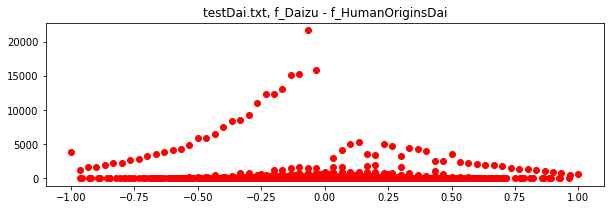

In [16]:
%matplotlib inline

import matplotlib.pyplot as plt
import collections

pd="/mnt/solexa/mel_yang/BGI/"

myfile=open(pd+"testDai.txt",'r')
diff=[]
locationinfo=[]
bases=collections.defaultdict(int)
totals=collections.defaultdict(int)
for line in myfile: 
    x=line.strip().split('\t')
    freq1=float(x[2])
    freq2=float(x[-1])
    diff.append(freq1-freq2)
    totals[''.join(sorted(x[5]))]+=1
    if freq1-freq2 ==-1: #in [-1,1]:
        locationinfo.append((x[0],x[1],x[5],x[6]))
        bases[''.join(sorted(x[5]))]+=1
        
for i in bases: print i,bases[i],totals[i],float(bases[i])/sum(bases.values()),float(totals[i])/sum(totals.values())
    
diff=collections.Counter(diff)
print diff[0]
del diff[0]
vals=[diff[i] for i in sorted(diff.keys())]

fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(1,1,1) 
ax.plot(sorted(diff.keys()),vals,'or')
ax.set_title("testDai.txt, f_Daizu - f_HumanOriginsDai")

## Results from above
for "in [-1,1]"
AC 389 45394 0.0859858532272 0.0815176498264
GT 460 57007 0.101679929266 0.102372046166
AG 2029 252411 0.448496905393 0.453274695121
CT 1646 202049 0.363837312113 0.362835608886

for "==-1"
AC 347 45394 0.0881829733164 0.0815176498264
GT 392 57007 0.0996188055909 0.102372046166
AG 1752 252411 0.445235069886 0.453274695121
CT 1444 202049 0.366963151207 0.362835608886

AC 4264 290479 0.152394567548 0.149539662536
GT 4307 295390 0.153931379557 0.152067863482
AG 6765 477901 0.241779842745 0.24602520067
CG 3421 250144 0.122265904217 0.128775055496
AT 2926 196458 0.104574696212 0.101137304323
CT 6297 432116 0.225053609721 0.222454913492
840638


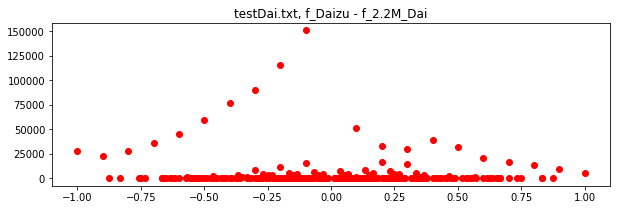

In [24]:
%matplotlib inline

import matplotlib.pyplot as plt
import collections

pd="/mnt/solexa/mel_yang/BGI/"

myfile=open(pd+"testDai_2.2vsBGI.txt",'r')
diff=[]
locationinfo=[]
bases=collections.defaultdict(int)
totals=collections.defaultdict(int)
for line in myfile: 
    x=line.strip().split('\t')
    freq1=float(x[2])
    freq2=float(x[-1])
    diff.append(freq1-freq2)
    totals[''.join(sorted(x[5]))]+=1
    if freq1-freq2 ==-1: #in [-1,1]:
        locationinfo.append((x[0],x[1],x[5],x[6]))
        bases[''.join(sorted(x[5]))]+=1
        
for i in bases: print i,bases[i],totals[i],float(bases[i])/sum(bases.values()),float(totals[i])/sum(totals.values())
    
diff=collections.Counter(diff)
print diff[0]
del diff[0]
vals=[diff[i] for i in sorted(diff.keys())]

fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(1,1,1) 
ax.plot(sorted(diff.keys()),vals,'or')
ax.set_title("testDai.txt, f_Daizu - f_2.2M_Dai")

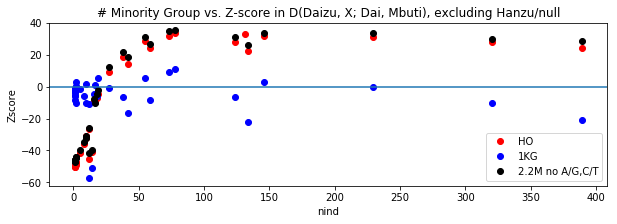

In [23]:
%matplotlib inline

import matplotlib.pyplot as plt
import collections

pd="/mnt/solexa/mel_yang/BGI/"

myfile=open(pd+"DaizuvsDai_minority_nind_Z.txt",'r')
nind,zscore=[],[]
for line in myfile: 
    x=line.strip().split('\t')
    if x[0]=="Daizu": continue
    if x[0]=="Hanzu": continue
    nind.append(int(x[1]))
    zscore.append(float(x[2]))
myfile.close()

myfile=open(pd+"DaizuvsCDX_minority_nind_Z.txt",'r')
nind1KG,zscore1KG=[],[]
for line in myfile: 
    x=line.strip().split('\t')
    if x[0]=="Daizu": continue
    if x[0]=="Hanzu": continue
    nind1KG.append(int(x[1]))
    zscore1KG.append(float(x[2]))
myfile.close()

myfile=open(pd+"Daizuvs2.2MDai_minority_nind_Z.txt",'r')
nind2,zscore2=[],[]
for line in myfile: 
    x=line.strip().split('\t')
    if x[0]=="Daizu": continue
    if x[0]=="Hanzu": continue
    nind2.append(int(x[1]))
    zscore2.append(float(x[2]))
myfile.close()


fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(1,1,1) 
ax.plot(nind,zscore,'or',label="HO")
ax.plot(nind1KG,zscore1KG,'ob',label="1KG")
ax.plot(nind2,zscore2,'o',color="black",label="2.2M no A/G,C/T")
ax.set_title("# Minority Group vs. Z-score in D(Daizu, X; Dai, Mbuti), excluding Hanzu/null")
ax.set_xlabel("nind")
ax.set_ylabel("Zscore")
ax.axhline(y=0)
plt.legend(loc="lower right")
